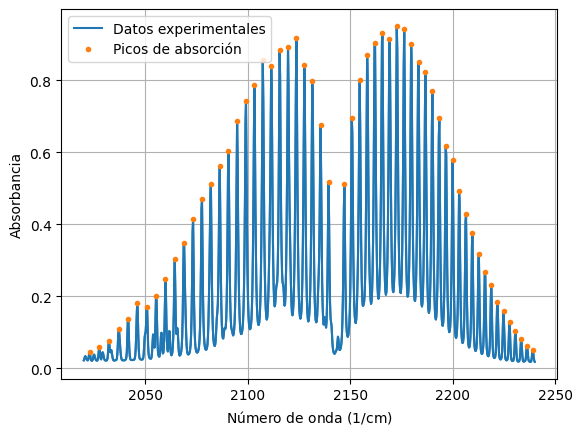

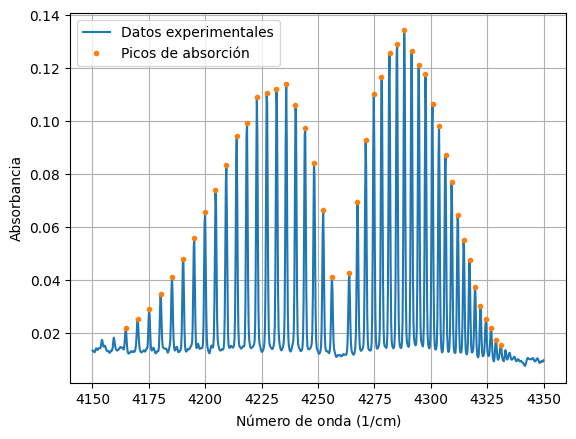

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from numpy import array,zeros,sort,where,transpose,arange,concatenate

def truncar(desde,hasta,datos):
  i1=where(datos[:,0]>=desde)[0][0]
  i2=where(datos[:,0]>=hasta)[0][0]
  return transpose(array([datos[i1:i2,0],datos[i1:i2,1]]))

datos=pd.read_csv("CO_HR_2.csv",header=4).values
datos1=truncar(2020,2240,datos)

plt.plot(datos1[:,0],datos1[:,1])

indices1=find_peaks(datos1[:,1],distance=10)[0]

picos1=zeros((len(indices1),2))

for k in range(len(indices1)):
  picos1[k,0]=datos1[indices1[k],0]
  picos1[k,1]=datos1[indices1[k],1]

plt.plot(datos1[:,0],datos1[:,1],label="Datos experimentales",color="tab:blue")
plt.plot(concatenate([picos1[0:28,0],picos1[29:,0]]),concatenate([picos1[0:28,1],picos1[29:,1]]),".",label="Picos de absorción",color="tab:orange")


plt.xlabel(r"Número de onda $(1/\text{cm})$")
plt.ylabel("Absorbancia")
plt.legend()
plt.grid()
plt.savefig("cero_a_uno.png",dpi=600)
plt.show()

datos2=truncar(4150,4350,datos)


indices2=find_peaks(datos2[:,1],prominence=0.005)[0]
picos2=zeros((len(indices2),2))

for k in range(len(indices2)):
  picos2[k,0]=datos2[indices2[k],0]
  picos2[k,1]=datos2[indices2[k],1]


plt.plot(datos2[:,0],datos2[:,1],label="Datos experimentales",color="tab:blue")
plt.plot(picos2[:,0],picos2[:,1],".",label="Picos de absorción",color="tab:orange")

plt.xlabel(r"Número de onda $(1/\text{cm})$")
plt.ylabel("Absorbancia")
plt.legend()
plt.grid()
plt.savefig("cero_a_dos.png",dpi=600)
plt.show()

In [ ]:
from numpy import pi,std,vectorize,full
from numpy.random import normal
from scipy.optimize import minimize
d1=where(picos1[:,0]>=2137)[0][0]
d2=where(picos2[:,0]>=4255)[0][0]
h=6.62607015e-34
hbarra=h/(2*pi)
c=299792458
e=1.602176634e-19

eomega=[]
eji=[]
edb0=[]
eb0alfa=[]

def proceso(iterar=False):

  BandaPnu1=picos1[:d1+1,0]
  BandaRnu1=picos1[d1+2:,0]
  BandaPnu2=picos2[:d2+1,0]
  BandaRnu2=picos2[d2+1:,0]
  Pnu1=arange(1,len(BandaPnu1)+1)[::-1]
  Rnu1=arange(0,len(BandaRnu1))
  Pnu2=arange(1,len(BandaPnu2)+1)[::-1]
  Rnu2=arange(0,len(BandaRnu2))
  if iterar:
    BandaPnu1=BandaPnu1+vectorize(normal)(0,full(len(BandaPnu1),0.25))
    BandaRnu1=BandaRnu1+vectorize(normal)(0,full(len(BandaRnu1),0.25))
    BandaPnu2=BandaPnu2+vectorize(normal)(0,full(len(BandaPnu2),0.25))
    BandaRnu2=BandaRnu2+vectorize(normal)(0,full(len(BandaRnu2),0.25))




  #Curvas teoricas
  curva_BRnu1=lambda A,J: A[0]*(1-2*A[1])+A[2]*(J+1)-A[3]*(J**2+4*J+3)
  curva_BPnu1=lambda A,J: A[0]*(1-2*A[1])-A[2]*J-A[3]*(J**2-2*J)
  curva_BRnu2=lambda A,J: 2*A[0]*(1-3*A[1])+A[2]*(J+1)-A[3]*(2*J**2+7*J+5)
  curva_BPnu2=lambda A,J: 2*A[0]*(1-3*A[1])-A[2]*J-A[3]*(2*J**2-3*J)

  conv=100*h*c/e
  def jicuad(A):
    ji=0
    for i in range(len(BandaPnu1)):
      ji+=(curva_BPnu1(A,Pnu1[i])-BandaPnu1[i])**2
    for i in range(len(BandaRnu1)):
      ji+=(curva_BRnu1(A,Rnu1[i])-BandaRnu1[i])**2
    for i in range(len(BandaPnu2)):
      ji+=(curva_BPnu2(A,Pnu2[i])-BandaPnu2[i])**2
    for i in range(len(BandaRnu2)):
      ji+=(curva_BRnu2(A,Rnu2[i])-BandaRnu2[i])**2
    return ji


  res=minimize(jicuad,[0.269/conv, 0.0061/conv, 0.00048/conv, 0.00000215/conv]).x
  if iterar:
    eomega.append(res[0])
    eji.append(res[1])
    edb0.append(res[2])
    eb0alfa.append(res[3])
  else:

    hbaromega=res[0]
    jianhar=res[1]
    dosb0=res[2]
    b0alfa=res[3]

    print("B0: " +str(dosb0/2)+" 1/cm +- " +str(edb0/2))
    print("alfa_e: "+str(2*b0alfa/dosb0)+" +- "+str(((eb0alfa*2/dosb0)**2+(edb0*2*b0alfa/dosb0**2)**2)**0.5))
    print("ji: "+str(jianhar)+" +- "+str(eji))
    print("omega: "+str(hbaromega)+" 1/cm "+str(eomega))

    plt.xlabel(r"Número cuántico rotacional $J$")
    plt.ylabel(r"Energía de absorción $(1/\text{cm})$")
    plt.errorbar(Pnu1,BandaPnu1,fmt=".",yerr=0.25,label="Datos banda P")
    plt.errorbar(Rnu1,BandaRnu1,fmt=".",yerr=0.25,label="Datos banda R")
    plt.plot(Pnu1,curva_BPnu1(res,Pnu1),label="Ajuste banda P")
    plt.plot(Rnu1,curva_BRnu1(res,Rnu1),label="Ajuste banda R")
    plt.legend()
    plt.grid()
    plt.savefig("nu1.png",dpi=600)
    plt.show()

    plt.xlabel(r"Número cuántico rotacional $J$")
    plt.ylabel(r"Energía de absorción $(1/\text{cm})$")
    plt.errorbar(Pnu2,BandaPnu2,fmt=".",yerr=0.25,label="Datos banda P")
    plt.errorbar(Rnu2,BandaRnu2,fmt=".",yerr=0.25,label="Datos banda R")
    plt.plot(Pnu2,curva_BPnu2(res,Pnu2),label="Ajuste banda P")
    plt.plot(Rnu2,curva_BRnu2(res,Rnu2),label="Ajuste banda R")
    plt.legend()
    plt.grid()
    plt.savefig("nu2.png",dpi=600)
    plt.show()



for i in range(1000):
  proceso(iterar=True)

eomega=std(eomega)
eji=std(eji)
edb0=std(edb0)
eb0alfa=std(eb0alfa)

proceso(iterar=False)
